In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

def find_duplicate_rows(X):
    Z = X
    # 将数组中的每一行表示为元组，并将这些元组存储在列表中
    row_tuples = [tuple(row) for row in Z]

    # 使用Python的collections.Counter来计算元组的出现次数
    row_counts = Counter(row_tuples)

    # 初始化总的重复次数
    total_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 打印重复行的行号（索引）和它们的重复次数，并计算总的重复次数
    for index, row in enumerate(Z):
        row_tuple = tuple(row)
        if row_tuple not in counted_rows:
            count = row_counts[row_tuple]
            if count > 1:
                duplicate_indices = [i for i, r in enumerate(Z) if tuple(r) == row_tuple]
                print(f"行 {index} 重复了 {count} 次，与行 {duplicate_indices} 重复")
                total_duplicate_count += count
            counted_rows.add(row_tuple)  # 将该行添加到已计数的行集合中

    # 打印总的重复次数
    print(f"总的重复次数为: {total_duplicate_count}")

    # 初始化总的不同重复行数
    total_unique_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 计算不同的重复行数
    for row_tuple, count in row_counts.items():
        if count > 1:
            total_unique_duplicate_count += 1
            counted_rows.add(row_tuple)

    # 打印总的不同重复行数
    print(f"总的不同重复行数为: {total_unique_duplicate_count}")

In [3]:
import pandas as pd

folder_path = "original_data/"

df = pd.read_excel(folder_path + 'data.S2.xlsx')

columns = df.columns

print(df.shape,columns)

(88, 27) Index(['Class', 'Solution treatment time (h)',
       'Solution treatment temperature (℃)', 'Solution cooling way',
       'Aging treatment time (h)', 'Aging treatment temperature (℃)',
       'Aging cooling way', '2nd aging treatment time (h)',
       '2nd aging treatment temperature (℃)', '2nd aging cooling way',
       'C (mass%)', 'Si (mass%)', 'Ni (mass%)', 'Mo (mass%)', 'W (mass%)',
       'Al (mass%)', 'N (mass%)', 'Nb+Ta (mass%)', 'B (mass%)', 'V (mass%)',
       'Ti (mass%)', 'Fe (mass%)', 'Zr (mass%)', 'Sn (mass%)',
       'Test temperature (℃)', 'Test stress (MPa)', 'Creep rupture life (h)'],
      dtype='object')


In [4]:
x_exp = df.iloc[:, 1:-1].values  # 假设编号列是第0列，x列从第2列到倒数第二列
y_exp = df.iloc[:, -1].values  # 最后一列作为y
print(x_exp.shape)
print(y_exp.shape)

(88, 25)
(88,)


# 合并重复数据

In [5]:
find_duplicate_rows(x_exp)

总的重复次数为: 0
总的不同重复行数为: 0


In [6]:
def merge_and_average_duplicates(X, Y):
    # 将X中的每一行表示为元组，并将这些元组存储在列表中
    row_tuples = [tuple(row) for row in X]

    # 使用Python的collections.Counter来计算元组的出现次数
    row_counts = Counter(row_tuples)

    # 创建一个新的数组来存储合并后的X和对应的Y
    merged_X = []
    merged_Y = []

    # 创建一个字典来存储每一行对应的Y的累加和和计数
    y_sums = {}
    y_counts = {}

    # 遍历原始数组，合并X和对应的Y，并计算Y的累加和和计数
    for index, (x_row, y_value) in enumerate(zip(X, Y)):
        x_tuple = tuple(x_row)
        if x_tuple not in y_sums:
            y_sums[x_tuple] = y_value
            y_counts[x_tuple] = 1
        else:
            y_sums[x_tuple] += y_value
            y_counts[x_tuple] += 1

    # 遍历字典，计算平均值，并将结果添加到新数组中
    for x_tuple, y_sum in y_sums.items():
        count = y_counts[x_tuple]
        averaged_y = y_sum / count
        merged_X.append(list(x_tuple))
        merged_Y.append(averaged_y)

    return np.array(merged_X), np.array(merged_Y)

# 使用示例
X_exp, Y_exp = merge_and_average_duplicates(x_exp, y_exp)

print(X_exp.shape,x_exp.shape )
print(Y_exp.shape,y_exp.shape)

(88, 25) (88, 25)
(88,) (88,)


In [7]:
find_duplicate_rows(X_exp)

总的重复次数为: 0
总的不同重复行数为: 0


# 对x进行minmax+pca+minmax

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_exp_mm = scaler.fit_transform(X_exp)

In [9]:
from sklearn.decomposition import PCA

def PCA_dim_select(selected_method, n_dims):
    if selected_method == 'auto':
        assert type(n_dims) == float
        selected_dim = n_dims
    elif selected_method == 'assigned':
        # assert type(n_dims) == int
        selected_dim = int(n_dims)
    return selected_dim

pca_dims = 0.95
pca = PCA(n_components=PCA_dim_select('auto', pca_dims))

x_exp_mm_pca = pca.fit_transform(x_exp_mm)
print(x_exp_mm_pca.shape)

(88, 7)


In [10]:
scaler1 = MinMaxScaler()
x_exp_mm_pca_mm = scaler1.fit_transform(x_exp_mm_pca)

# 对y进行log

In [11]:
y_log = np.log(Y_exp)

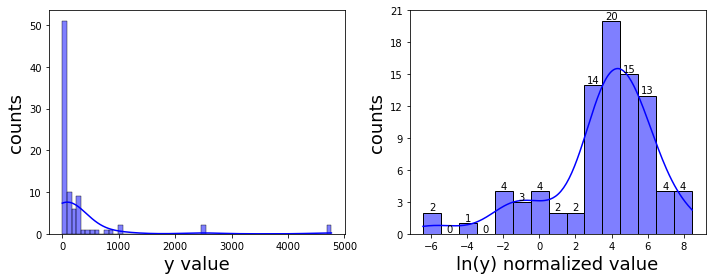

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(y_exp, kde=True, color='blue', ax=axes[0])
axes[0].set_xlabel('y value', fontsize=18)  
axes[0].set_ylabel('counts', fontsize=18)   

sns.histplot(y_log, kde=True, color='blue', ax=axes[1])
axes[1].set_xlabel('ln(y) normalized value', fontsize=18)  
axes[1].set_ylabel('counts', fontsize=18)  
axes[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

heights = [p.get_height() for p in axes[1].patches]
for i, height in enumerate(heights):
    if height.is_integer():  
        axes[1].annotate(str(int(height)), (axes[1].patches[i].get_x() + axes[1].patches[i].get_width() / 2, height),
                         ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# x与y合并为数据集

In [13]:
columns = [f'x{i+1}' for i in range(x_exp_mm_pca_mm.shape[1])]
x_df = pd.DataFrame(x_exp_mm_pca_mm, columns=columns)
y_df = pd.DataFrame(y_log, columns=['y_log'])
merged_data = pd.concat([x_df, y_df], axis=1)
merged_data.to_excel('processed_data/s2_data.xlsx', index=False)